We compare different representations on two datasets/architectures:

 - A small convnet on MNIST with 1,001 parameters on the full MNIST dataset
 - A Resnet50 on CIFAR10 with 23,467,722 parameters on 100 CIFAR10 examples
 
In the convnet example, since we do not have so many parameters, we are also able to visualize FIMs.

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as tF
import torch.nn as nn
import time

import matplotlib.pyplot as plt


from nngeometry.layercollection import LayerCollection
from nngeometry.metrics import FIM_MonteCarlo1
from nngeometry.object.vector import random_pvector

from nngeometry.object import PMatDiag, PMatKFAC, PMatEKFAC, PMatLowRank, PMatBlockDiag, PMatQuasiDiag, PMatImplicit, PVector, PMatDense

# Small convnet on MNIST

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, 3, 1)
        self.conv2 = nn.Conv2d(5, 6, 4, 1)
        self.conv3 = nn.Conv2d(6, 7, 3, 1)
        self.fc1 = nn.Linear(1*1*7, 10)

    def forward(self, x):
        x = tF.relu(self.conv1(x))
        x = tF.max_pool2d(x, 2, 2)
        x = tF.relu(self.conv2(x))
        x = tF.max_pool2d(x, 2, 2)
        x = tF.relu(self.conv3(x))
        x = tF.max_pool2d(x, 2, 2)
        x = x.view(-1, 1*1*7)
        x = self.fc1(x)
        return tF.log_softmax(x, dim=1)

trainset = datasets.MNIST(root='/tmp/', train=True, download=True,
                           transform=transforms.ToTensor())
trainloader = DataLoader(
    dataset=trainset,
    batch_size=1000,
    shuffle=False)
    
convnet = ConvNet().to('cuda')

layer_collection = LayerCollection.from_model(convnet)
v = random_pvector(LayerCollection.from_model(convnet), device='cuda')

layer_collection.numel()

1001

In [3]:
def compute_correlation(M):
    diag = torch.diag(M)
    dM = (diag + diag.mean() / 100) **.5
    return torch.abs(M) / dM.unsqueeze(0) / dM.unsqueeze(1)

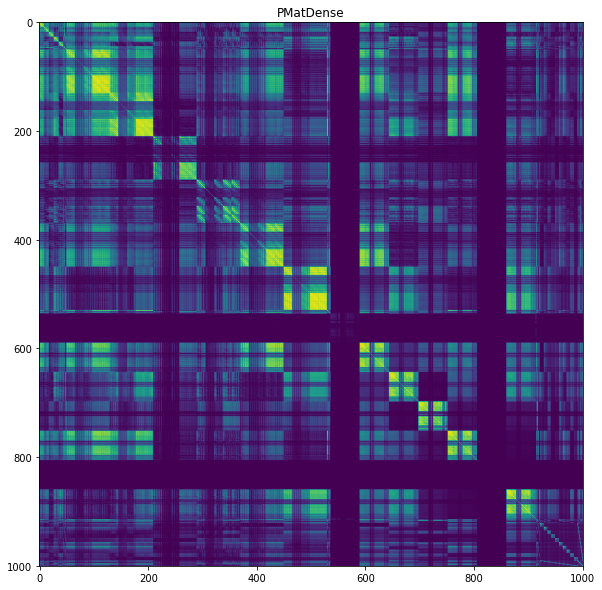

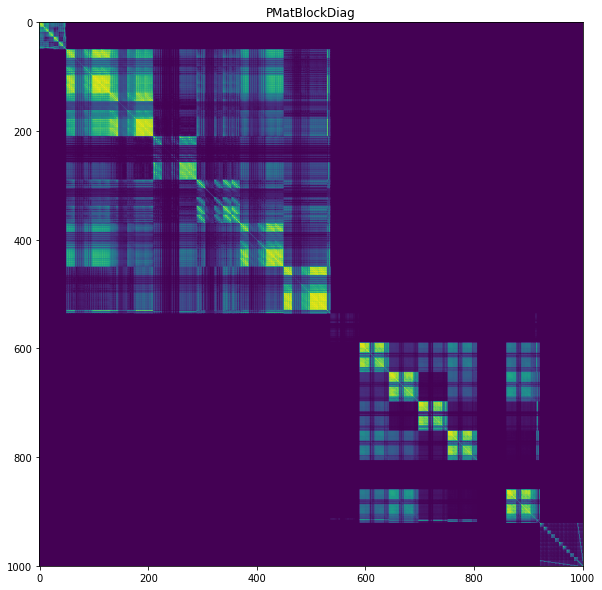

<Figure size 720x720 with 0 Axes>

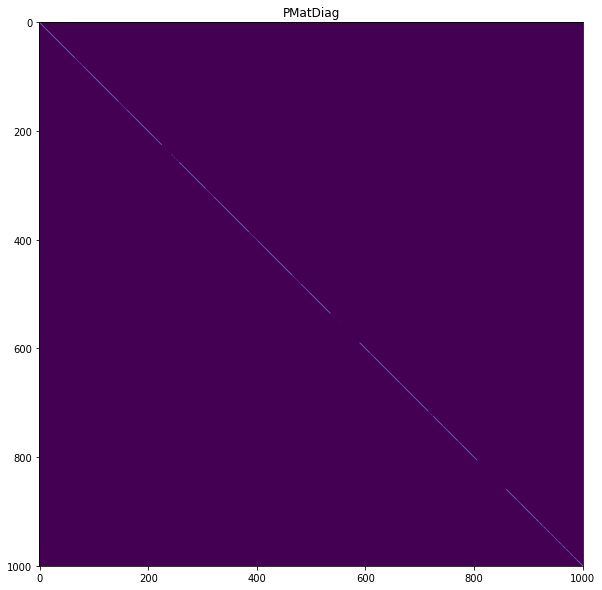

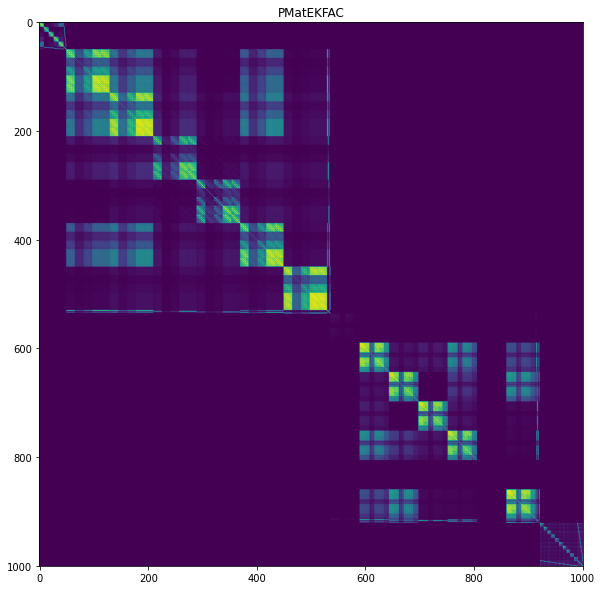

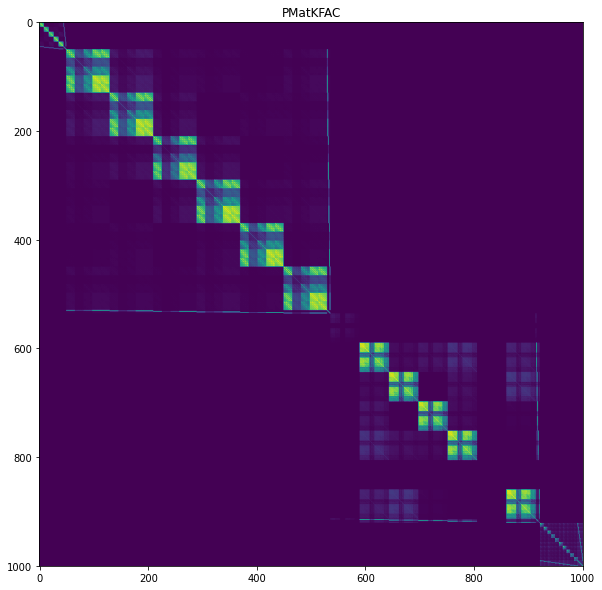

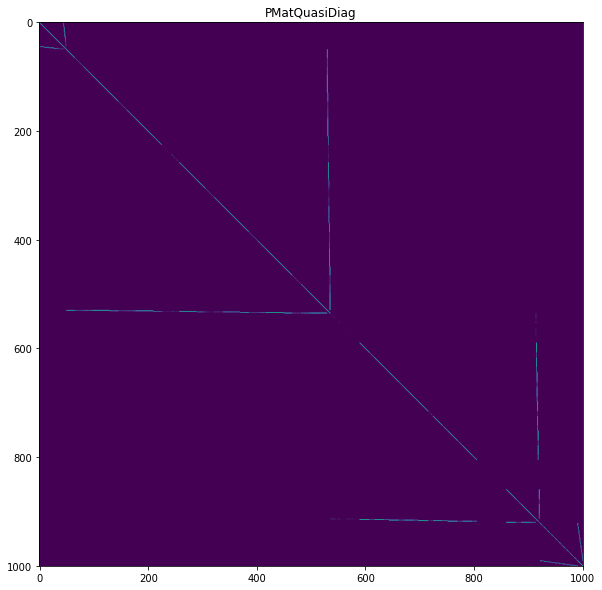

In [4]:
# compute timings and display FIMs

timings = dict()

for repr in [PMatDense, PMatBlockDiag, PMatImplicit, PMatDiag, PMatEKFAC, PMatKFAC, PMatQuasiDiag]:
    
    timings[repr] = dict()
    
    time_start = time.time()
    F = FIM_MonteCarlo1(model=convnet,
                        loader=trainloader,
                        representation=repr,
                        device='cuda')
    time_end = time.time()
    timings[repr]['init'] = time_end - time_start
    
    if repr == PMatEKFAC:
        time_start = time.time()
        F.update_diag()
        time_end = time.time()
        timings[repr]['update_diag'] = time_end - time_start
        
    time_start = time.time()
    F.mv(v)
    time_end = time.time()
    timings[repr]['Mv'] = time_end - time_start
    
    time_start = time.time()
    F.vTMv(v)
    time_end = time.time()
    timings[repr]['vTMv'] = time_end - time_start
    
    time_start = time.time()
    F.trace()
    time_end = time.time()
    timings[repr]['tr'] = time_end - time_start
    
    try:
        time_start = time.time()
        F.frobenius_norm()
        time_end = time.time()
        timings[repr]['frob'] = time_end - time_start
    except NotImplementedError:
        pass
    
    try:
        time_start = time.time()
        F.solve(v)
        time_end = time.time()
        timings[repr]['solve'] = time_end - time_start
    except:
        pass
    
    try:
        time_start = time.time()
        F_dense = F.get_dense_tensor()
        time_end = time.time()
        timings[repr]['get_dense'] = time_end - time_start
    except:
        pass
    
    try:
        repr_name = str(repr).split('.')[-1][:-2]
        plt.figure(figsize=(10, 10))
        plt.imshow(compute_correlation(F_dense).cpu())
        plt.title(repr_name)
        plt.savefig('repr_img/'+ repr_name + '.png')
        plt.show()
        plt.close()
        
        del F_dense
        
    except:
        pass
    
    del F

In [5]:
timings

{nngeometry.object.pspace.PMatDense: {'init': 12.953430891036987,
  'Mv': 0.013498306274414062,
  'vTMv': 0.011524438858032227,
  'tr': 0.007066249847412109,
  'frob': 0.0128021240234375,
  'solve': 0.15862393379211426,
  'get_dense': 2.6226043701171875e-06},
 nngeometry.object.pspace.PMatBlockDiag: {'init': 12.811818599700928,
  'Mv': 0.0009899139404296875,
  'vTMv': 0.006165742874145508,
  'tr': 0.0005013942718505859,
  'frob': 0.0018131732940673828,
  'solve': 0.03444838523864746,
  'get_dense': 0.0002741813659667969},
 nngeometry.object.pspace.PMatImplicit: {'init': 0.00020647048950195312,
  'Mv': 8.65626835823059,
  'vTMv': 7.813796520233154,
  'tr': 12.303749322891235},
 nngeometry.object.pspace.PMatDiag: {'init': 12.341254711151123,
  'Mv': 8.130073547363281e-05,
  'vTMv': 0.00018334388732910156,
  'tr': 6.031990051269531e-05,
  'frob': 8.821487426757812e-05,
  'solve': 0.00013303756713867188,
  'get_dense': 8.988380432128906e-05},
 nngeometry.object.pspace.PMatEKFAC: {'init': 1

# ResNet50 on CIFAR10

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='/tmp/data', train=True,
                                        download=True, transform=transform)
trainset = torch.utils.data.Subset(trainset, range(100))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified


In [7]:
from resnet import ResNet50
resnet = ResNet50().cuda()

layer_collection = LayerCollection.from_model(resnet)
v = random_pvector(LayerCollection.from_model(resnet), device='cuda')

layer_collection.numel()

23467722

In [8]:
# compute timings and display FIMs

timings = dict()

for repr in [PMatImplicit, PMatDiag, PMatEKFAC, PMatKFAC, PMatLowRank, PMatQuasiDiag]:
    
    timings[repr] = dict()
    
    time_start = time.time()
#     F = repr(generator=generator)
    F = FIM_MonteCarlo1(model=resnet,
                        loader=trainloader,
                        representation=repr,
                        device='cuda')
    time_end = time.time()
    timings[repr]['init'] = time_end - time_start
    
    if repr == PMatEKFAC:
        time_start = time.time()
        F.update_diag()
        time_end = time.time()
        timings[repr]['update_diag'] = time_end - time_start
        
    time_start = time.time()
    F.mv(v)
    time_end = time.time()
    timings[repr]['Mv'] = time_end - time_start
    
    time_start = time.time()
    F.vTMv(v)
    time_end = time.time()
    timings[repr]['vTMv'] = time_end - time_start
    
    time_start = time.time()
    F.trace()
    time_end = time.time()
    timings[repr]['tr'] = time_end - time_start
    
    try:
        time_start = time.time()
        F.frobenius_norm()
        time_end = time.time()
        timings[repr]['frob'] = time_end - time_start
    except NotImplementedError:
        pass
    
    try:
        time_start = time.time()
        F.solve(v)
        time_end = time.time()
        timings[repr]['solve'] = time_end - time_start
    except:
        pass
    
    del F

In [9]:
timings

{nngeometry.object.pspace.PMatImplicit: {'init': 0.0033528804779052734,
  'Mv': 0.7807552814483643,
  'vTMv': 0.4677009582519531,
  'tr': 0.7919890880584717},
 nngeometry.object.pspace.PMatDiag: {'init': 0.7915208339691162,
  'Mv': 0.001172780990600586,
  'vTMv': 0.002067089080810547,
  'tr': 0.0004508495330810547,
  'frob': 0.00048542022705078125,
  'solve': 0.0019822120666503906},
 nngeometry.object.pspace.PMatEKFAC: {'init': 14.055991172790527,
  'update_diag': 1.198657751083374,
  'Mv': 0.07345414161682129,
  'vTMv': 0.04482293128967285,
  'tr': 0.003618955612182617,
  'frob': 0.006207942962646484},
 nngeometry.object.pspace.PMatKFAC: {'init': 1.0143547058105469,
  'Mv': 0.0357511043548584,
  'vTMv': 0.041136980056762695,
  'tr': 0.008361101150512695,
  'frob': 0.1886310577392578},
 nngeometry.object.pspace.PMatLowRank: {'init': 1.2285540103912354,
  'Mv': 0.2762744426727295,
  'vTMv': 0.226607084274292,
  'tr': 0.779510498046875,
  'frob': 0.7774031162261963},
 nngeometry.object.p